<a href="https://colab.research.google.com/github/lshpy/DeepLearning_basic/blob/main/5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 교차 검증과 그리드 서치(어려움 주의)


In [28]:
# 문제점: 테스트 세트를 자주 사용하게 되면 결국 테스트 세트에 잘 맞는 모델이 만들어지는 것
# 테스트 세트는 가장 마지막에 딱 한번 사용하는 것이 가장 바람직하다!

# 테스트 세트 말고 모델의 과소/과대적합을 판단할 기준: 검증 세트


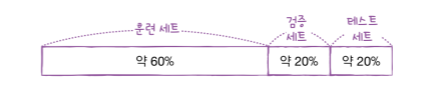

In [29]:
#1. 훈련세트에서 모델을 훈련, 검증세트에서 평가
#2. 매개변술ㄹ 바꾸어 가면서 가장 좋은 모델을 선택
#3. 훈련세트랑 검증세트를 합쳐서 전체 훈련데이터에서 모델을 다시 훈련
#4. 마지막 테스트 세트에서 최종점수를 평가

In [30]:
import pandas as pd
wine  = pd.read_csv('http://bit.ly/wine_csv_data')

In [31]:
data = wine.iloc[:, :-1].to_numpy()
target = wine['class'].to_numpy()

In [32]:
# 데이터 분할 (훈련, 테스트)

from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2,random_state=42
)

In [33]:
# 데이터 분할2(훈련, 검증)

sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size = 0.2, random_state=42)

In [34]:
print(sub_input.shape, val_input.shape)

# sub, val : (훈련, 검증)

(4157, 3) (1040, 3)


In [35]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

dt.fit(sub_input, sub_target)

print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

0.9971133028626413
0.8596153846153847


교차 검증

검증세트를 꼐어 내어 평가하는 과정을 여러번 반복

In [36]:
# cross_validate
# 1. 먼저 평가할 모델 객체를 첫번째 매개변수로 전달
# 2. 직접 검증세트를 떼어내지 않고 훈련세트 전체를 전달

In [37]:
from sklearn.model_selection import cross_validate

scores = cross_validate(dt, train_input, train_target)
print(scores)

# fit _time : 훈련시간
# score_time : 검증시간
# test_socre : 5-폴드 교차 검증
# cv매개변수에서 폴드 수를 변경할 수 있음


{'fit_time': array([0.00840807, 0.00819373, 0.00848508, 0.0087347 , 0.00797272]), 'score_time': array([0.00124264, 0.00127625, 0.00123787, 0.00132298, 0.00115514]), 'test_score': array([0.87115385, 0.84807692, 0.88065448, 0.85466795, 0.83830606])}


In [38]:
import numpy as np
print(np.mean(scores['test_score']))
# 5개의 스코어의 평균을 낸 것
# 최상의 검증 점수를 확인 가능

0.858571851632487


In [39]:
# 훈련세트를 섞는 과정
from sklearn.model_selection import StratifiedKFold

scores = cross_validate(dt, train_input, train_target, cv = StratifiedKFold())
print(np.mean(scores['test_score']))

0.8574174502110017


In [40]:
# 10-폴드 교차 검증

splitter = StratifiedKFold(n_splits = 10, shuffle=True, random_state=42)
# 10번 새로 분할하라
# shuffle = True

scores = cross_validate(dt, train_input, train_target, cv = splitter)
print(np.mean(scores['test_score']))

0.8576115310508374


하이퍼파라미터 튜닝

In [41]:
# 머신러닝모델이 학습하는 파라미터
# 하이퍼파라미터: 사용자가 지정해야하는 파라미터
# 사이킷런 : 머신러닝 라이브러리 : 클래스/매개변수


# max_depth, min_samples_split을 동시에 바꾸면서 최적의 값을 찾아야 한다
# for 반복문으로 구현 > 그리드 서치


In [42]:
# 그리드 서치 호출
from sklearn.model_selection import GridSearchCV

params = {'min_impurity_decrease': [0.0001, 0.0002, 0.0003, 0.004, 0.005]}
# 5개의 값을 준비 한다

# 그리드 서치의 객체를 생성
gs = GridSearchCV(DecisionTreeClassifier(random_state = 42),
                  params, n_jobs=-1)

# min_impurity_decrease' 값을 바꿔가면 5번씩 실행
# 5*5 = 25

# 그리드 서치를 수행
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.004, 0.005]})

In [43]:
# 검증 점수가 가 장 높은 모델의 매개변수로 지정

dt = gs.best_estimator_
print(dt.score(train_input, train_target))

0.9615162593804117


In [44]:
print(gs.best_params_)
# 가장 좋은 값으로 선택됨

{'min_impurity_decrease': 0.0001}


In [45]:
print(gs.cv_results_['mean_test_score'])

[0.86819297 0.86453617 0.86492226 0.85414803 0.85318557]


In [46]:
best_index = np.argmax(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['params'][best_index])

{'min_impurity_decrease': 0.0001}


In [47]:
# 변수를 더 복잡하게!

params = {'max_impurity_decrease': np.arange(0.0001, 0.001, 0.0001),
          'max_depth': range(5,20,1), 'min_samples_split':range(2,100,10)}


In [49]:
# 변수를 더 복잡하게!

params = {'min_impurity_decrease': np.arange(0.0001, 0.001, 0.0001), # 'max_impurity_decrease'를 'min_impurity_decrease'로 수정
          'max_depth': range(5,20,1), 'min_samples_split':range(2,100,10)}

gs = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  params, n_jobs  =-1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [50]:
print(np.max(gs.cv_results_['mean_test_score']))

# 매개변수 값을 나열하면 자동으로 교차검증을 수행해서 최상의 매개변수를 찾을 수 있음

0.8683865773302731


랜덤 서치

매개변수의 목록을 작성해서 주는 것은 범위나 간격에서 제약이 있음

--> 확률분포의 객체를 전달한다

scipy

In [55]:
from scipy.stats import uniform, randint
# 클래스 안 주어진 범위에서 고르게 값을 뽑는다
# uniform : 실숫값
# randint : 정숫값

In [59]:
rgen = randint(0,10) # 0에서 10사이의 범위를 갖는 정수 객체를 만들자
rgen.rvs(10) # 10개의 무작위 샘플을 반환

array([4, 1, 4, 9, 6, 0, 5, 2, 2, 5])

In [58]:
np.unique(rgen.rvs(1000), return_counts = True)
# 고유한 값이 0~9 가 각각 몇번 나타났는지를 보여주는 2개의 배열
# 비슷하게 추출된것을 알 수 있다!

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([111,  91, 119, 116,  96,  85,  90,  95,  91, 106]))

In [60]:
ugen = uniform(0,1)
ugen.rvs(10)

array([0.49410964, 0.64346423, 0.81966988, 0.39392884, 0.08611632,
       0.11527661, 0.84483561, 0.24624359, 0.86810256, 0.49577337])

In [65]:
# 매개변수의 범위 재설정(scipy)

params  = {'min_impurity_decrease': uniform(0.0001, 0.001),
           'max_depth': randint(20,50), # 트리의 최대깊이
           'min_samples_split':randint(2,25), # 시작 노드의 최소 샘플 수
           'min_samples_leaf': randint(1,25),} # 마지막 노드의 샘플 최소수

In [66]:
# 모델 훈련

from sklearn.model_selection import RandomizedSearchCV

gs  = RandomizedSearchCV(DecisionTreeClassifier(random_state=42),
    params, n_iter = 100, n_jobs = -1, random_state=42)

gs.fit(train_input, train_target)

# n_iter : 무작위 조합을 몇번 선택할 것인지를 정해줌
# n_jobs : 컴퓨터의 프로세서를 몇개를 사용할 것인가
# random_state : 랜덤성을 제어하기위한 시드 값을 설정한다, 아니면 코드 중간에 돌릴때마다 계속 다은 값이 나옴



RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fbb72f51120>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fbb72f50d00>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fbb72f532b0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fbb72f53700>},
                   random_state=42)

In [68]:
# 최적의 매개변수 조합은?

print(gs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}


In [70]:
# 교차검증의 점수는?

print(np.max(gs.cv_results_['mean_test_score']))

0.8695428296438884


In [73]:
# 테스트 세트의 점수는?

dt = gs.best_estimator_
print(dt.score(test_input, test_target))

0.86
